In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Dynamical systems - Sheet 1

## Exercise 1 - simple SIR model
Throughout this exercise dynamical systems need solving, since they are all defined as differential equations, the forward euler method seems appropriate:

In [2]:
# Implementing the forward Euler to solve multidimensional differential equations
def solve(dx_dt, x0, dt, T):
    N = int(T/dt) # the number of integration steps required to reach T

    x = np.zeros((N+1, len(x0))) # initialize data array
    x[0,:] = x0
    
    t = [0,]
    
    for i in range(int(T/dt)):
        xt = x[i,:]
        xtp = xt + dx_dt(xt) * dt # calculate the forward-euler step

        x[i+1,:] = xtp
        t.append(t[-1] + dt)
    
    return x, t


## 1.1
We use the differential equation solver to write a function that solves and plots the simple SIR model.

In [11]:
def solve_SIR(beta, gamma, T):
    N = 1000

    x0 = [600, 1, N - 600 - 1] # the initial condition

    def sir(x):
        # calculate the derivative of the state x
        infecting = beta * x[0] * x[1] / N
        recovering = gamma * x[1]

        ds = - infecting
        di = + infecting - recovering
        dr = + recovering 

        return np.array([ds, di, dr])

    x, t = solve(sir, x0, 0.001, T) # solve the SIR model numerically

    labels = ['susceptible', 'infected', 'recovered']

    for i, label in enumerate(labels):
        plt.plot(t, x[:,i], label = label) # plot the evolution of the SIR model

    plt.legend()


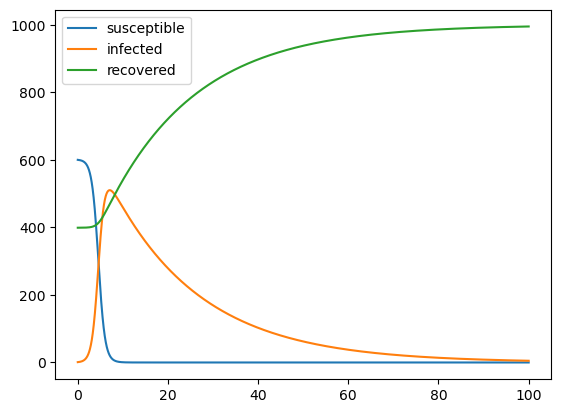

In [12]:
solve_SIR(2.4, 1./20, 100)

We can see a spike of infections at the start which then dies down as the population becomes immune.

## 1.2
Next we'll introduce a factor $\delta$ that controlls the speed at which recovered people become susceptible again.

In [34]:
def solve_SIR_unimmune(beta, gamma, delta, T):
    N = 1000
    x0 = [999, 1, 0]

    def sir(x):
        infecting = beta * x[0] * x[1] / N
        recovering = gamma * x[1]
        unimmuning = delta * x[2]

        ds = - infecting + unimmuning
        di = - recovering + infecting 
        dr = - unimmuning + recovering

        return np.array([ds, di, dr])

    x, t = solve(sir, x0, 0.001, T)

    labels = ['susceptible', 'infected', 'recovered']

    for i, label in enumerate(labels):
        plt.plot(t, x[:,i], label = label)

    plt.legend()

Im not really sure what the two distinct dynamics are...

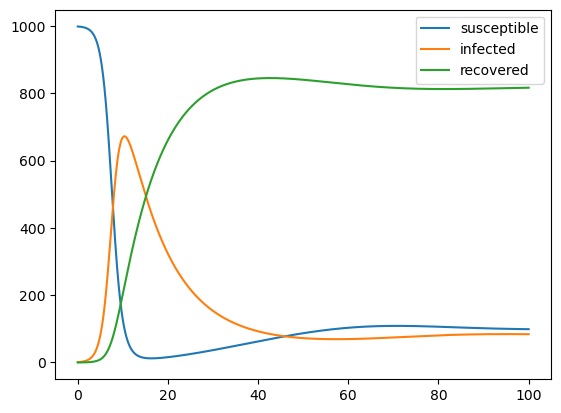

In [31]:
solve_SIR_unimmune(1, 0.1, 0.01, 100)

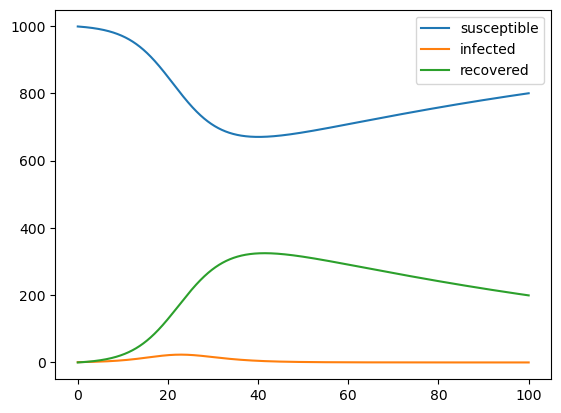

In [33]:
solve_SIR_unimmune(1, 0.8, 0.01, 100)

## 1.3
We will now introduce an additional population: the dead

In [35]:
def solve_SIR_die(beta, gamma, delta, mu, T):
    N = 1000
    x0 = [999, 1, 0, 0]

    def sir(x):
        infecting = beta * x[0] * x[1] / N
        recovering = gamma * x[1]
        unimmuning = delta * x[2]
        dying = mu * x[1] # infected can now also transition to the dead

        ds = - infecting + unimmuning
        di = - recovering - dying + infecting 
        dr = - unimmuning + recovering
        dd = + dying

        return np.array([ds, di, dr, dd])

    x, t = solve(sir, x0, 0.001, T)

    labels = ['susceptible', 'infected', 'recovered', 'dead']

    for i, label in enumerate(labels):
        plt.plot(t, x[:,i], label = label)

    plt.legend()

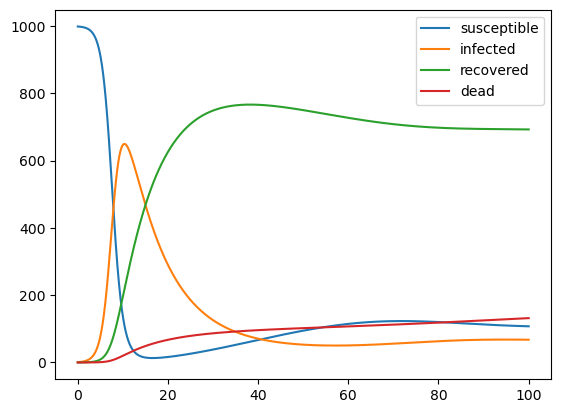

In [40]:
solve_SIR_die(1, 0.1, 0.01, 0.01, 100)

## Exercise 2 - Higher order ODEs
Let $f(t, x, d_t x, d_t^2 x, ..., d_t^n x) = 0$ where $d_t = \frac{d}{dt}$. <br> <br>
We can rearrange this to $g(t, x, d_t^2 x, ..., d_t^{n-1} x) = d_t^n x$. <br> <br>
With the substitution $y_i = d_t^{i-1} x$ this results in a system of n first order ODEs:
$$d_t y_1 = y_2$$ 
$$d_t y_2 = y_3$$ 
$$...$$ 
$$d_t y_n = g(t, y_1, ..., y_n)$$ 

## Exercise 3 - ODEs on real time

$$x \in \!R \ \textrm{ with } \ \dot{x} = Ax \ \textrm{ and } A \in \!R$$
Solutions to this linear, one-dimensional ODE are exponetial growth, decay or a constant value. <br>
To get osciallatory behavior we would need a second order time derivative (or equivalently a two dimensional ODE)

## Exercise 4 - Flow field of linear ODEs
## 4.1
The fixed points of the system are defined by $\dot x = Ax \stackrel{!}{=} 0$, using this we get:
$$\begin{bmatrix} 0.1 & -0.3 \\ 0.2 & -0.3 \\ \end{bmatrix} * x = 0$$
$$\widehat{=}$$
$$0.1 x_0 - 0.3 x_1 = 0\ \ \ (I) \\ 0.2 x_0 - 0.3 x_1 = 0\ \ (II)$$
$$\stackrel{I + II}{\implies}$$
$$0.3 x_0 = 0 \implies x_0 = 0$$
$$\stackrel{x_0=0 \textrm{ into }I}{\implies}$$
$$-0.3 x_1 = 0 \implies x_1 = 0$$
This means, that there is one fixed point at $x = (0\ 0)^T$ <br>

## 4.2
The evolution of the system for an initial condition of $x_0 = (1\ \ 0)^T$

In [100]:
A = np.array([[0.1, -0.3],[0.2, -0.3]])
x0 = np.array([1, 0])

x, t = solve(lambda x: A.dot(x), x0, 0.001, 100)

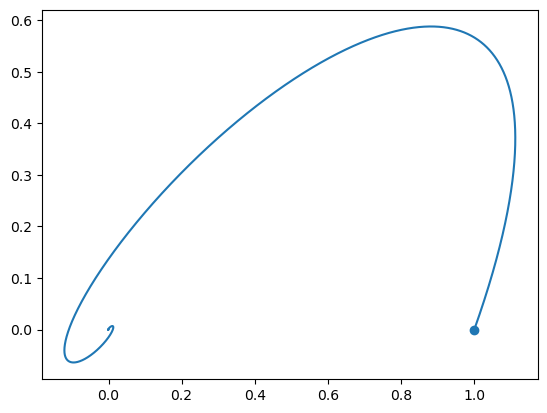

In [101]:
plt.scatter(*x0)
plt.plot(x[:,0], x[:,1])

## 4.3
We can plot the flowfield of this system:

In [113]:
def calc_vectorfield(f, lim):
    # Some parameters of the grid
    num = 10

    # First create the points where the vectors will be ancored
    xy = np.array([[x, y] for y in np.linspace(-lim,lim,num) for x in np.linspace(-lim,lim,num)]) # there has to be a better way to do this...

    # Calculate the derivative at each gridpoint
    uv = np.array([f(xy_) for xy_ in xy])

    return *xy.T, *uv.T # returns in the format x, y, u, v instead of xy, uv

In [120]:
def plot_vectorfield(f, lim):
    x,y,u,v = calc_vectorfield(f, lim)

    plt.quiver(x,y,u,v)
    plt.axis('square')

Text(0, 0.5, '$x_1$')

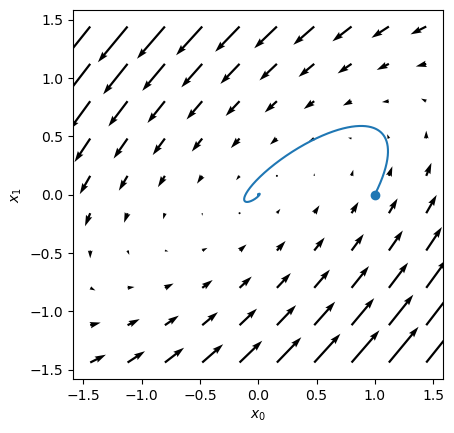

In [126]:
plot_vectorfield(lambda x: A.dot(x), 1.2)

plt.scatter(*x0)
plt.plot(x[:,0], x[:,1])

plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

## 4.4
We can now repeat the analysis from above with systems that display the different types of dynamical behavior:

In [173]:
def plot_system(A, x0, title, T = 500):
    x, t = solve(lambda x: A.dot(x), x0, 0.001, T)
    
    plot_vectorfield(lambda x: A.dot(x), 1.2)

    plt.scatter(*x0)
    plt.plot(x[:,0], x[:,1])

    plt.title(title)
    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')

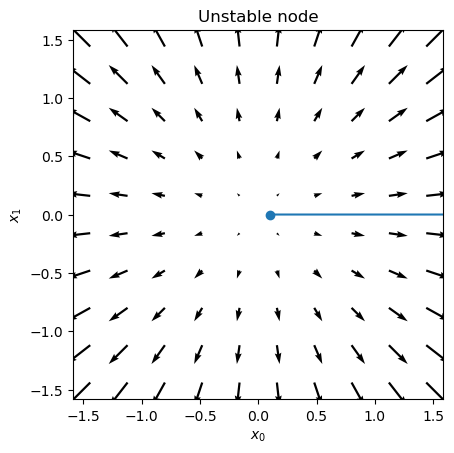

In [136]:
A = np.array([[1,0],[0,1]])
plot_system(A, [0.1,0], 'Unstable node')

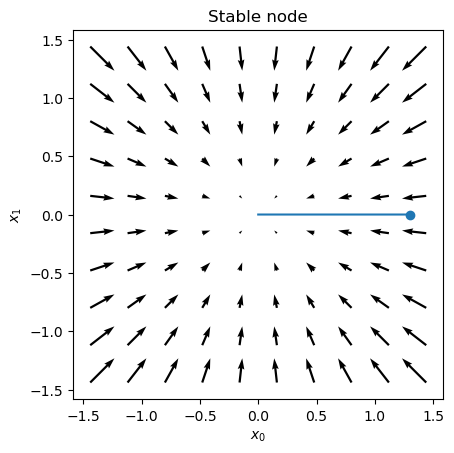

In [175]:
A = np.array([[-1,0],[0,-1]])
plot_system(A, [1.3,0], 'Stable node')

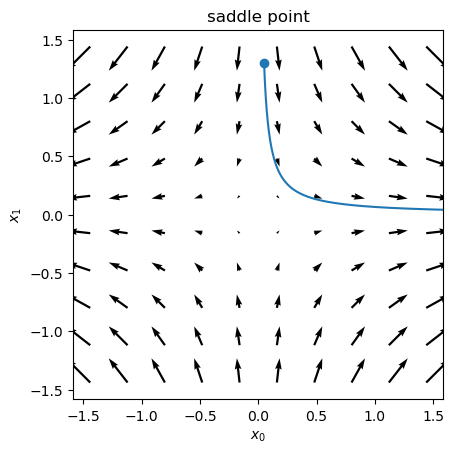

In [144]:
A = np.array([[1,0],[0,-1]])
plot_system(A, [0.05,1.3], 'Saddle point')

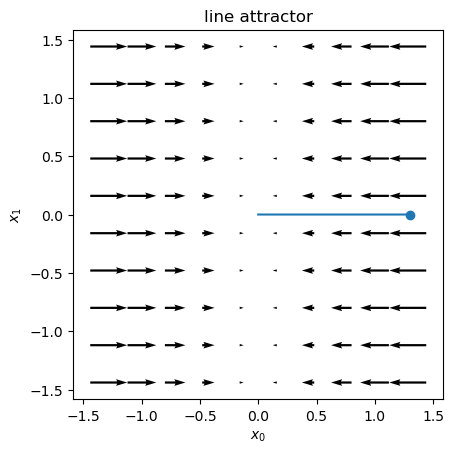

In [148]:
A = np.array([[-1,0],[0,0]])
plot_system(A, [1.3,0], 'Line attractor')

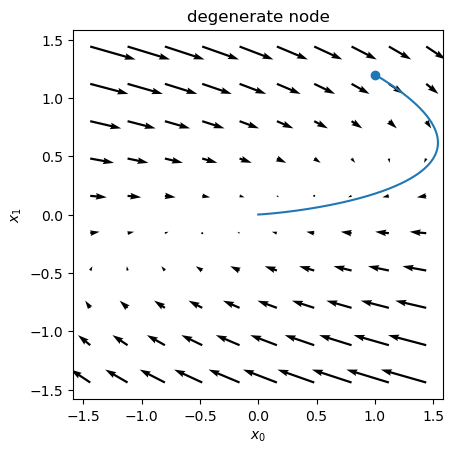

In [163]:
a = -0.4
A = np.array([[a,1],[0,a]])
plot_system(A, [1,1.2], 'Degenerate node')

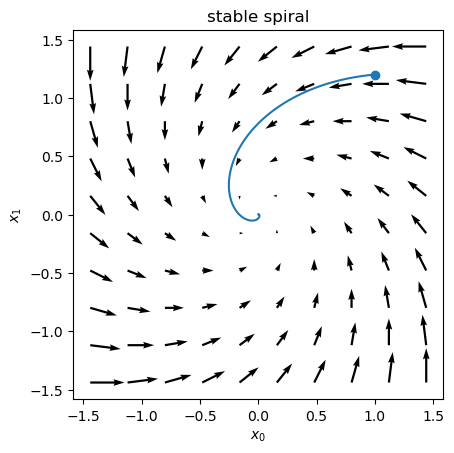

In [166]:
A = np.array([[-1,-1],[1,-1]])
plot_system(A, [1,1.2], 'Stable spiral')

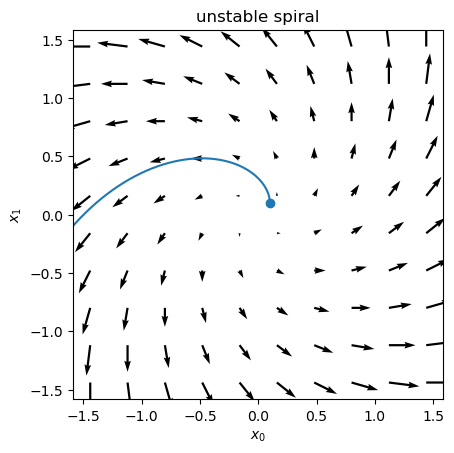

In [169]:
A = np.array([[1,-1],[1,1]])
plot_system(A, [0.1,0.1], 'Unstable spiral')

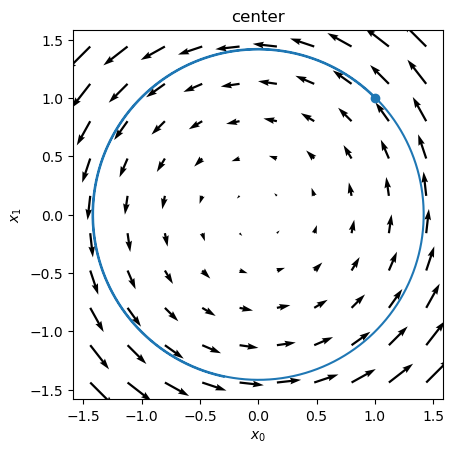

In [174]:
A = np.array([[0,-1],[1,0]])
plot_system(A, [1,1], 'Center', T = 10)